# Visualize Auditory SC

In [1]:
from __future__ import division
import sys
import numpy as np
import joblib
import pylab as plt
%matplotlib inline
import h5py
import os
import glob
import yaml
from pulp.em.camodels.bsc_et import BSC_ET
from pulp.em.annealing import LinearAnnealing
from sklearn.feature_extraction.image import reconstruct_from_patches_2d
from sklearn.metrics import mean_squared_error
plt.rcParams['image.cmap'] = 'viridis'
#np.seterr(all='raise')

In [6]:
model_name = 'generic_modelc0'

with open('model_specifications/' + model_name + '.yml','r') as fh:
    model_specifications = yaml.load(fh)

data = joblib.load(model_specifications['data'])
if isinstance(data,dict):
    patchsize = data['patchsize']
    data = data['data']
else:
    patchsize = (4,48)

model_specifications['D'] = patchsize[0] * patchsize[1]

In [3]:
with h5py.File(glob.glob('output/'+model_name+'*')[0] + '/result.h5','r') as results:
    L,  mu, W, sigma, pi = [results[key][()] for key in ['L',
                                                       'mu',
                                                       'W',
                                                       'sigma',
                                                       'pi']]


IndexError: list index out of range

In [4]:
for key,value in model_specifications.iteritems():
    print "{} = {}".format(key,value)

name = fewdatac0
H = 50
n_anneal = 100
D = 192
N_cut = [(0, 2.0), (0.25, 1.0)]
T = [(0.0, 6.0), (0.3, 1.0)]
Hprime = 6
data = /home/mboos/MasterThesis/data/preprocessed/200ms_patches_zscored_sixth.pkl
gamma = 4
W_noise = [(0, 2.0), (0.3, 0.0)]


## Likelihood over iterations

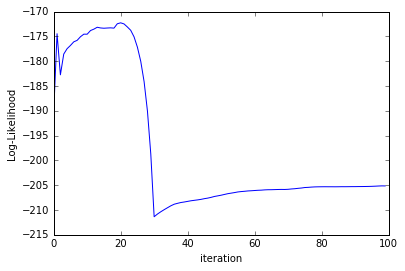

In [5]:
plt.plot(L)
plt.xlabel('iteration')
plt.ylabel('Log-Likelihood')

## $H\pi$ (sparsity) over iterations

H = 50


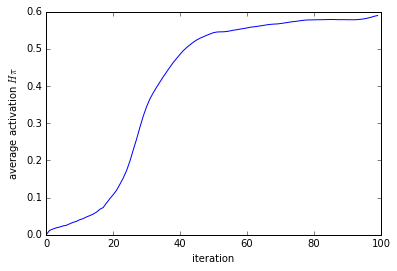

In [6]:
print('H = {}'.format(model_specifications['H']))
plt.plot(pi*model_specifications['H'])
plt.xlabel('iteration')
plt.ylabel(r'average activation $H\pi$')

## $\sigma$ over iterations

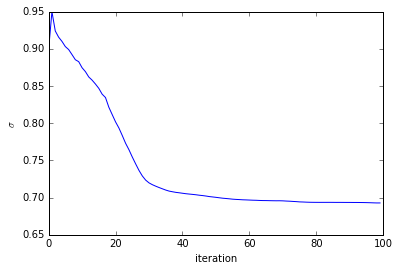

In [7]:
plt.plot(sigma)
plt.xlabel('iteration')
plt.ylabel(r'$\sigma$')

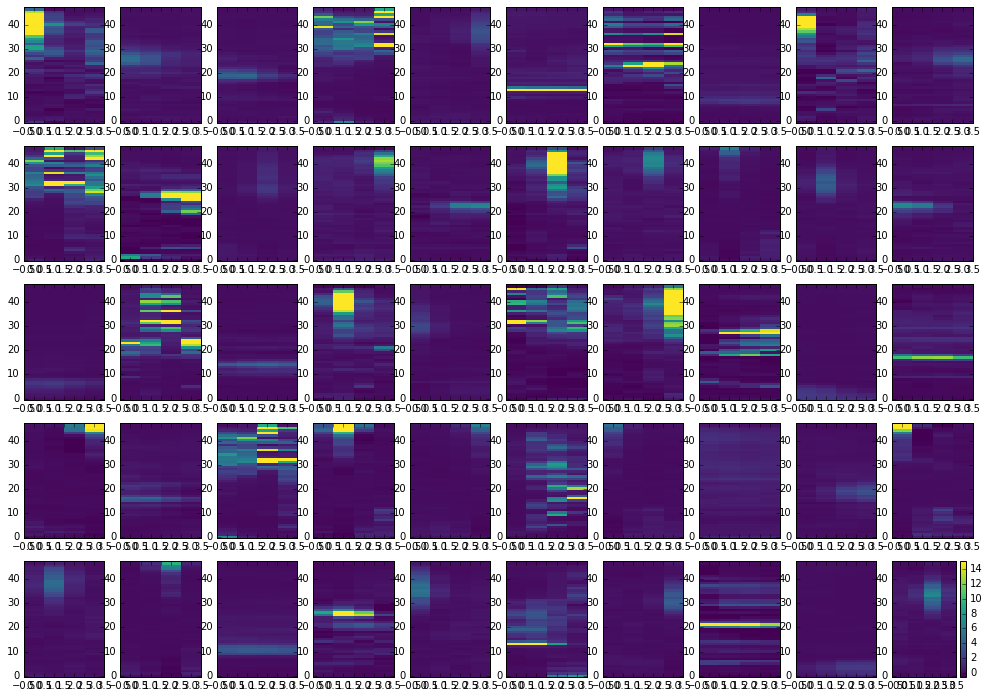

In [11]:
ts = -1
test_W = np.reshape(W[ts,:,:].T,(model_specifications['H'],) + patchsize)
#test_W = np.swapaxes(test_W.T,1,2)
plt.figure(figsize=(17,12))

Wmin, Wmax = np.percentile(test_W,1), np.percentile(test_W,99)

for i,comp in enumerate(test_W):
    plt.subplot(np.ceil(model_specifications['H']/10),10,i+1)
    plt.imshow(comp.T,origin='lower',interpolation='nearest',aspect='auto',cmap='viridis',vmin=Wmin,vmax=Wmax)

plt.colorbar()

    

## Compute the posterior expectation of the data

In [12]:

bsc = BSC_ET(*[model_specifications[key] for key in ['D','H','Hprime','gamma']])

data = {'y':data}
model_params = {'W':W[-1],'pi':pi[-1],'sigma':sigma[-1]}

anneal = LinearAnnealing(1)
anneal['T'] = [(0,1.)]
inferred_data = bsc.inference(anneal,model_params,data,no_maps=5)

test_patches = np.reshape(data['y'],(data['y'].shape[0],)+patchsize)

#inferred_data = {key:np.squeeze(value) for key,value in inferred_data.iteritems()}

In [13]:
reconstructed =  mu[-1][np.newaxis,:] + inferred_data['s'][:,0,:].dot(model_params['W'].T)
reconstructed_patches = np.reshape(reconstructed,(reconstructed.shape[0],)+patchsize)

In [14]:
rec_data = reconstruct_from_patches_2d(reconstructed_patches,(reconstructed_patches.shape[0] + reconstructed_patches.shape[1] - 1,patchsize[1]))
test_data = reconstruct_from_patches_2d(test_patches,(test_patches.shape[0]+test_patches.shape[1]-1,patchsize[1]))
joblib.dump({'original':test_data,'reconstructed':rec_data},'results/reconstructed/{}.pkl'.format(model_name),compress=3)

## Validate Model

### Mean-squared error

In [ ]:
mse = mean_squared_error(test_data,rec_data)
print 'Mean-squared error: {} \nshape = {}'.format(mse,test_data.shape)

### Original Spectrogram

In [ ]:
vmin = min([np.min(test_data[2000:2200]),np.min(rec_data[2000:2200])])
vmax = max([np.max(test_data[2000:2200]),np.max(rec_data[2000:2200])])

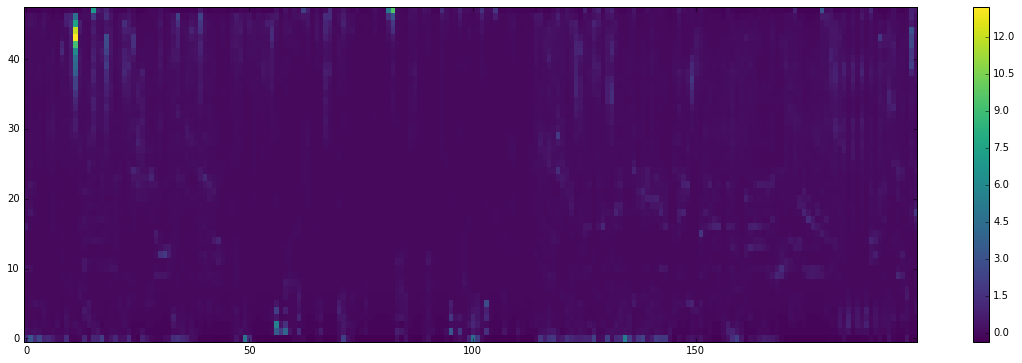

In [28]:
plt.figure(figsize=(20,6))
plt.imshow(test_data[2000:2200].T,origin='lower',aspect='auto',interpolation='nearest',vmin=vmin,vmax=vmax)
plt.colorbar()

### Reconstructed Spectrogram

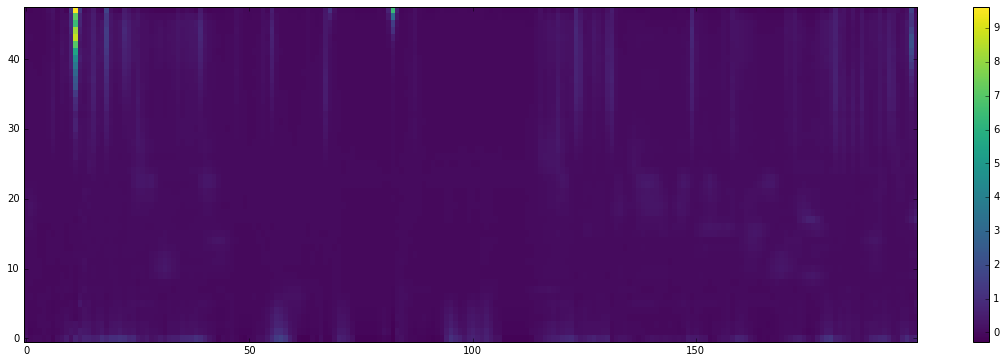

In [29]:
plt.figure(figsize=(20,6))
plt.imshow(rec_data[2000:2200].T,origin='lower',aspect='auto',interpolation='nearest',vmin=vmin,vmax=vmax)
plt.colorbar()